In [30]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
from statsmodels.stats import proportion

### Задание: проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
### Описание датасета:
#### У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста. Когда игрок устанавливал игру, он или она случайным образом попадали в одну из них.
#### userid - Уникальный номер, идентифицирующий каждого игрока.
#### version - Игрок в контрольной группе gate_30. Игрок в тестируемой группе gate_40.
#### sum_gamerounds - Количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
#### retention_1 - Вернулся ли игрок в игру после первого дня от установки (0 - нет, 1 - да).
#### retention_7 - Вернулся ли игрок в игру после 7 дней от установки (0 - нет, 1 - да). 

In [4]:
df = pd.read_csv('результаты А_B - cookie_cats 2.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


### Очистка данных.
#### 1) Проверим данные на совпадение типов и пропущенные значения:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [6]:
df.isnull().value_counts()

userid  version  sum_gamerounds  retention_1  retention_7
False   False    False           False        False          90189
dtype: int64

#### 2) Проверим есть ли повторы в уникальных номерах игроков:

In [7]:
df.userid.duplicated().value_counts()

False    90189
Name: userid, dtype: int64

#### Как видим данные чистые: типы данных соответствуют описанию метрики, пропущенных значений нет, дупликатов уникальных номеров также нет.

### Анализ данных: 
#### 1) Разобьем наш датасет на два - контрольную (df_30) и тестовую группы (df_40):

In [8]:
df_30 = df[df['version'] == 'gate_30']
df_30.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.470000e+04,44700.000000,44700.000000,44700.000000
mean,4.987564e+06,52.456264,0.448188,0.190201
std,2.881026e+06,256.716423,0.497314,0.392464
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505469e+06,5.000000,0.000000,0.000000
50%,4.983631e+06,17.000000,0.000000,0.000000
75%,7.481497e+06,50.000000,1.000000,0.000000
max,9.999710e+06,49854.000000,1.000000,1.000000


In [9]:
df_40 = df[df['version'] == 'gate_40']
df_40.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


#### Как видим из сводной статистики по двум группам, особых различий в среднем, стандартном отклонении и квантилях нет. Существенное отличие  есть в показателе max в контрольной группе - 49 854, посмотрим на него графически. 

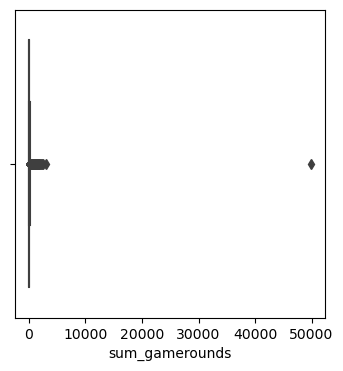

In [10]:
plt.figure(figsize=(4, 4))
sns.boxplot(df_30, x= 'sum_gamerounds');
plt.show()

#### Это единичный выброс, поэтому лучшего его исключить из выборки.

In [11]:
df_30 = df_30[df_30['sum_gamerounds'] < 10000]

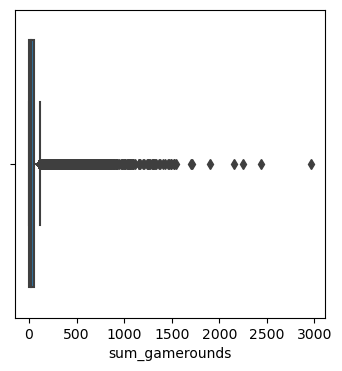

In [12]:
plt.figure(figsize=(4, 4))
sns.boxplot(df_30, x= 'sum_gamerounds');
plt.show()

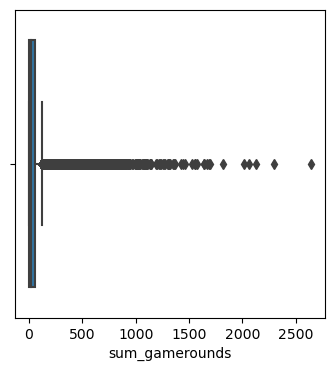

In [13]:
plt.figure(figsize=(4, 4))
sns.boxplot(df_40, x= 'sum_gamerounds');
plt.show()

#### 2) будем сравнивать две группы по трём метрикам sum_gamerounds, retention_1, retention_2.
### sum_gamerounds:


In [48]:
total_30 = df_30['sum_gamerounds'].sum()
total_40 = df_40['sum_gamerounds'].sum()

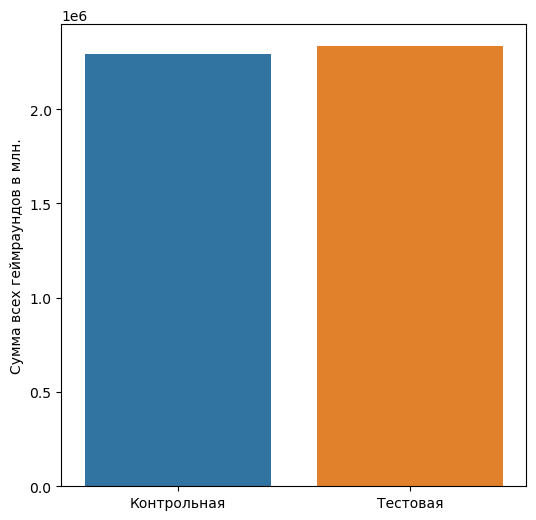

In [56]:
plt.figure(figsize=(6, 6))
sns.barplot(x=['Контрольная', 'Тестовая'], y=np.array([total_30, total_40]))
plt.ylabel('Сумма всех геймраундов в млн.')
plt.show()

In [62]:
print(total_40 - total_30)

38589


#### Как видим на диаграмме количество всех геймраундов выше в тестовой группе на 38 589. Проверим статистическую значимость данного отличия.
#### Но - гипотеза: данное отличие случайно. Н1 - гипотеза: отличие количества геймраундов в тестовой группе статистически значимо.


#### По двум вышележащим графикам видно, что метрика sum_gamerounds распределена не нормально, значит будем использовать критерий Манна-Уитни.

In [64]:
null_hypothesis = 'Увеличение количества геймраундов в тестовой группе случайно.'
alternive_hypothesis = 'Увеличение количества геймраундов в тестовой группе статистически значимо.'
alfa = 0.05

mw_stat = stats.mannwhitneyu(df_30['sum_gamerounds'], df_40['sum_gamerounds'])
mw_stat

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

In [65]:
if mw_stat[1] < alfa:
    print(alternive_hypothesis)
else:
    print(null_hypothesis)

Увеличение количества геймраундов в тестовой группе случайно.


### retention_1
#### Посчитаем процент возврата игроков в 1 день в двух группах:

In [16]:
ret_1_rate_30 = round(df_30.query('retention_1 == 1').shape[0] / df_30['retention_1'].shape[0], 3) 
ret_1_rate_40 = round(df_40.query('retention_1 == 1').shape[0] / df_40['retention_1'].shape[0], 3) 

In [17]:
print('Процент возврата игроков в 1 день в контрольной группе:', ret_1_rate_30*100)
print('Процент возврата игроков в 1 день в тестовой группе:', ret_1_rate_40*100)

Процент возврата игроков в 1 день в контрольной группе: 44.800000000000004
Процент возврата игроков в 1 день в тестовой группе: 44.2


#### Отличия незначительые: уменьшение в тестовой группе на 0,6 %. Необходимо убедиться, что данное отличие имеет значимость или просто случайность.
#### Но - гипотеза: снижение процента возврата игроков случайность, Н1 - гипотеза: данное снижение статистически значимо.
#### Воспользуемся z-тестом для пропорций

In [29]:
# количество вернувшихся игроков в контрольной группе
k_30 = df_30['retention_1'].sum()

# общее количество игроков в контрольной группе
n_30 = df_30['retention_1'].shape[0]

# количество вернувшихся игроков в тестовой группе
k_40 = df_40['retention_1'].sum()

# общее количество игроков в тестовой группе
n_40 = df_40['retention_1'].shape[0]

In [37]:
null_hypothesis = 'Снижение процента возврата игроков случайность.'
alternive_hypothesis = 'Есть статистически значимые отличия в снижении процента возврата игроков.'
alfa = 0.05
prop_stat = proportion.proportions_ztest(np.array([k_30, k_40]), np.array([n_30, n_40]), alternative='two-sided')

if prop_stat[1] < alfa:
    print(alternive_hypothesis)
else:
    print(null_hypothesis)

Снижение процента возврата игроков случайность.


### retention_7
#### Посчитаем процент возврата игроков на 7 день в двух группах:

In [18]:
ret_7_rate_30 = round(df_30.query('retention_7 == 1').shape[0] / df_30['retention_7'].shape[0], 3) 
ret_7_rate_40 = round(df_40.query('retention_7 == 1').shape[0] / df_40['retention_7'].shape[0], 3) 

In [20]:
print('Процент возврата игроков на 7 день в контрольной группе:', ret_7_rate_30*100)
print('Процент возврата игроков на 7 день в тестовой группе:', ret_7_rate_40*100)

Процент возврата игроков на 7 день в контрольной группе: 19.0
Процент возврата игроков на 7 день в тестовой группе: 18.2


#### Отличия имеются: уменьшение в тестовой группе на 0,8 %. Необходимо убедиться, что данное отличие имеет значимость или просто случайность.
#### Но - гипотеза: снижение процента возврата игроков случайность, Н1 - гипотеза: данное снижение статистически значимо.
#### Воспользуемся z-тестом для пропорций

In [38]:
# количество вернувшихся игроков в контрольной группе
k_30 = df_30['retention_7'].sum()

# общее количество игроков в контрольной группе
n_30 = df_30['retention_7'].shape[0]

# количество вернувшихся игроков в тестовой группе
k_40 = df_40['retention_7'].sum()

# общее количество игроков в тестовой группе
n_40 = df_40['retention_7'].shape[0]

In [39]:
null_hypothesis = 'Снижение процента возврата игроков случайность.'
alternive_hypothesis = 'Есть статистически значимые отличия в снижении процента возврата игроков.'
alfa = 0.05
prop_stat = proportion.proportions_ztest(np.array([k_30, k_40]), np.array([n_30, n_40]), alternative='two-sided')

if prop_stat[1] < alfa:
    print(alternive_hypothesis)
else:
    print(null_hypothesis)

Есть статистически значимые отличия в снижении процента возврата игроков.


### Выводы:
### Проведенный анализ по трём метрикам показал, что различия в контрольной и тестовой группах есть, но статистически значимые только по метрике 7-дневного возврата (retention_7). C 95% уверенностью можно сказать, что изменения принятые в тестовой группе уменьшили 7-дневный возврат игроков на 0,8%. Рекомендовано: не применять изменения проведенные в тестовой группе.